# Windowing Part 1

Introduction
--------------

In the [prior section](http://python-for-signal-processing.blogspot.com/2013/03/spectral-estimation-using-discrete.html), we discovered that resolving two nearby frequencies depends crucially on the rectangular window and its corresponding `sinc` Discrete Fourier Transform (DFT). However, our two nearby signals had *equal* amplitudes. What happens when  this is no longer the case? The figure below shows the DFT of two nearby signals where one has ten times the amplitude. 

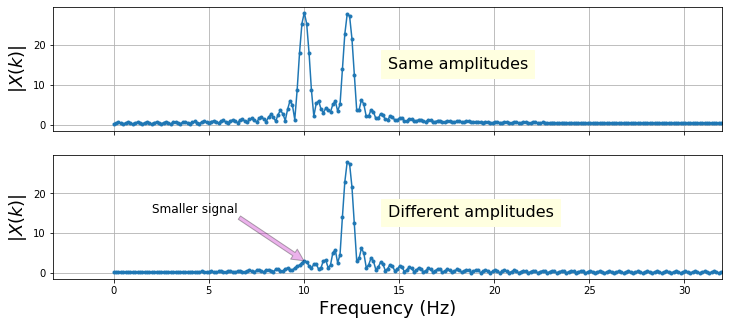

In [1]:
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy import abs, arange, array, exp, linspace, log, log10, cos, sin, sqrt, pi
from numpy.fft import fft, fftshift, fftfreq

figsize = {"figsize":(12,5)}


# some useful functions 
def dftmatrix(Nfft=32,N=None):
    'construct DFT matrix'
    k= arange(Nfft)
    if N is None: N = Nfft
    n = arange(N)
    U = np.matrix(exp(1j* 2*pi/Nfft *k*n[:,None])) # use numpy broadcasting to create matrix
    return U/sqrt(Nfft)


def db20(W,Nfft=None):
    'Given DFT, return power level in dB'
    if Nfft is None: # assume W is DFT 
        return 20*log10(abs(W))
    else: # assume time-domain passed, so need DFT
        return 20*log10(abs(fft(W,Nfft)/sqrt(Nfft) ) )

fs = 64 # sampling frequency
t = arange(0,2,1/fs)
f = 10  # one signal
deltaf = 2.3 # second nearby frequency

Nf = 512
fig,ax = plt.subplots(2,1,sharex=True,sharey=True,**figsize)

x=10*cos(2*pi*f*t) + 10*cos(2*pi*(f+deltaf)*t) # equal amplitudes
X = fft(x,Nf)/sqrt(Nf)
ax[0].plot(linspace(0,fs,len(X)),abs(X),'-o',ms=3.)
ax[0].set_ylabel(r'$|X(k)|$',fontsize=18)
ax[0].set_xlim(right = fs/2)
ax[0].grid()
ax[0].text(0.5,0.5,'Same amplitudes',
            transform=ax[0].transAxes,
            backgroundcolor='Lightyellow',
            fontsize=16)

x=cos(2*pi*f*t) + 10*cos(2*pi*(f+deltaf)*t) # one has 10x the amplitude
X = fft(x,Nf)/sqrt(Nf)
ax[1].plot(linspace(0,fs,len(X)),abs(X),'-o',ms=3.)
ax[1].set_ylabel(r'$|X(k)|$',fontsize=18)
ax[1].set_xlabel('Frequency (Hz)',fontsize=18)
ax[1].set_xlim(right = fs/2)
ax[1].grid()
ax[1].text(0.5,0.5,'Different amplitudes',
                transform=ax[1].transAxes,
                backgroundcolor='lightyellow',
                fontsize=16)
ax[1].annotate('Smaller signal',
            fontsize=12,xy=(f,abs(X)[int(f/fs*Nf)]),
            xytext=(2,15),
            arrowprops={'facecolor':'m','alpha':.3});

# fig.savefig('figure_00@.png', bbox_inches='tight', dpi=300)

In the figure above, the top plot shows the  two peaks of  nearby signals when they both have the same amplitude. The bottom plot shows the case where the higher frequency signal has ten times the amplitude. Note that the two frequencies are no longer resolvable because the weaker signal (smaller amplitude) has descended into the sidelobes of the  stronger one. Thus, we need more than just longer sampling durations and denser DFTs to resolve these signals. This is where *windows* (sometimes called *tapers*) come in. 

### What is a window?

A window is a function that is multiplied sample-by-sample against the input signal (i.e. element-wise).  For example, given an input signal, $s_n$, and a window, $w_n$, the new windowed signal is,

$$ y_n = s_n w_n $$

known in vector notation as the *Hadamard* product,

$$ \mathbf{y} = \mathbf{w} \odot \mathbf{s}  $$

The following figure compares the the rectangular and triangular windows applied to an input sinusoid.

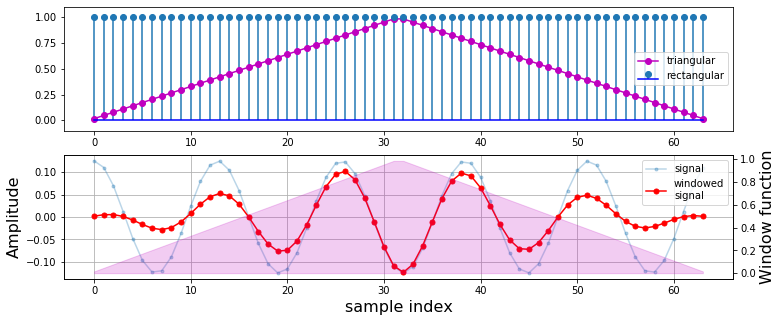

In [2]:
fig,axs = plt.subplots(2,1, **figsize)

Nf = 128
nsamp = 64
window = signal.triang(nsamp)
rectwin = np.ones(nsamp)
ax = axs[0]

ax.plot(arange(nsamp),window,'m-o',label='triangular')
ax.stem(arange(nsamp),rectwin,basefmt='b-',label='rectangular', use_line_collection=True)
ax.set_ylim(top = 1.1,bottom=-0.1)
ax.legend(loc=0)

x=array(dftmatrix(64,64)[:,5].real).flatten() # convert to numpy array
n = arange(len(x))
window = signal.triang(len(x))

ax = axs[1]
ax.plot(n,x,'-o',label='signal',ms=3.,alpha=0.3)
ax.plot(n,window*x,'-or',label='windowed\nsignal',ms=5.)
ax.set_ylabel('Amplitude',fontsize=16)
ax.set_xlabel('sample index',fontsize=16)
ax.legend(loc=0)
ax.grid()
ax2 = ax.twinx()
ax2.fill_between(n,window,alpha=0.2,color='m')
ax2.set_ylabel('Window function',fontsize=16);

# fig.savefig('figure_00@.png', bbox_inches='tight', dpi=300)


In the figure above, the top plot shows the $w_n$ sequences for the <font color="blue"> rectangular</font> and <font color="magenta"> triangular</font> windows. The bottom plot shows the input <font color="blue">signal before (light blue line) </font> and <font color="red"> after (red line)</font> applying the <font color="magenta">triangular window</font>. The amplitudes are noted on the vertical scale on the left. The triangular window is drawn in the background with scale noted on the right side. Basicially, the red line is the product of the blue line and the pink background window function. As shown, because the triangular window slopes to zero at  the beginning and at the end, the amplitude of the input signal drops away from the middle. This means that we lose precious signal energy at the start and end of the signal. We certainly want something in exchange for this! 

The following figure shows the two input signals with rectangular, triangular, and Hamming windows applied.

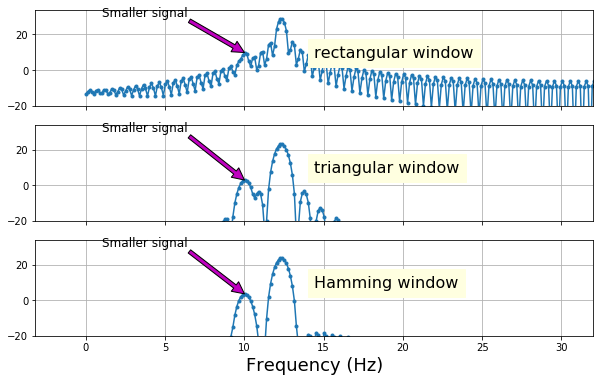

In [3]:
Nf = 512
fig,ax = plt.subplots(3,1,sharex=True,sharey=True)
fig.set_size_inches((10,6))

x=cos(2*pi*f*t) + 10*cos(2*pi*(f+deltaf)*t)
X = fft(x,Nf)/sqrt(Nf)
ax[0].plot(linspace(0,fs,len(X)),db20(X),'-o',ms=3.)
ax[0].set_xlim(right = fs/2)
ax[0].grid()
ax[0].text(0.5,0.5,'rectangular window',
                transform=ax[0].transAxes,
                backgroundcolor='lightyellow',
                fontsize=16)
ax[0].annotate('Smaller signal',
            fontsize=12,xy=(f,db20(X)[int(f/fs*Nf)]),
            xytext=(1,30),
            arrowprops={'facecolor':'m'})

w = signal.triang(len(x))
X = fft(x*w,Nf)/sqrt(Nf)
ax[1].plot(linspace(0,fs,len(X)),db20(X),'-o',ms=3.)
ax[1].set_xlim(right = fs/2)
ax[1].grid()
ax[1].text(0.5,0.5,'triangular window',
                transform=ax[1].transAxes,
                backgroundcolor='lightyellow',
                fontsize=16)
ax[1].annotate('Smaller signal',
            fontsize=12,xy=(f,db20(X)[int(f/fs*Nf)]),
            xytext=(1,30),
            arrowprops={'facecolor':'m'})

w = signal.windows.hamming(len(x))
X = fft(x*w,Nf)/sqrt(Nf)
ax[2].plot(linspace(0,fs,len(X)),db20(X),'-o',ms=3.)
ax[2].set_xlabel('Frequency (Hz)',fontsize=18)
ax[2].set_xlim(right = fs/2)
ax[2].grid()
ax[2].set_ylim(bottom=-20)
ax[2].text(0.5,0.5,'Hamming window',
                transform=ax[2].transAxes,
                backgroundcolor='lightyellow',
                fontsize=16)
ax[2].annotate('Smaller signal',
            fontsize=12,xy=(f,db20(X)[int(f/fs*Nf)]),
            xytext=(1,30),
            arrowprops={'facecolor':'m'});

# fig.savefig('figure_00@.png', bbox_inches='tight', dpi=300)


To enhance detail, the figure above shows the the $20\log_{10} | X_k |$ of the DFT of the input signal with noted  windows applied on the same scale. The top plot shows the rectangular window and we can barely make out the smaller signal in the sidelobes of the dominant larger signal. The middle plot shows the triangular window and we can see that there is definitely something peeking out from the sidelobes, but we can see this most clearly using the Hamming window (bottom plot), which shows a peak at the nearby frequency. Note that the width of the mainlobe widened as the second weaker signal emerged from the sidelobes of the  stronger  signal. This is one of the trade-offs involved when using windows for spectral analysis. 

## Summary

In this section, we demonstrated that window functions can help resolve nearby frequencies that have different amplitudes. As the plots showed, we traded precious signal energy for resolution, but we need a systematic framework for evaluating different window functions. This framework will be the topic of our next section.

As usual, the corresponding IPython notebook for this post  is available for download [here](https://github.com/unpingco/Python-for-Signal-Processing/blob/master/Windowing.ipynb). 

Comments and corrections welcome!

References
---------------

* Oppenheim, A. V., and A. S. Willsky. *Signals and Systems* Prentice-Hall, (1997).
* Proakis, John G. *Digital signal processing: principles algorithms and applications* Pearson Education India, 2001.